1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [2]:
import pandas as pd # standard naming convention
import numpy as np

In [3]:
pd.set_option('display.max_rows', 20)
file_name = "./data/data_000637.txt" #1310720 rows
N = 1310720
df = pd.read_csv(file_name, nrows = N)
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14
1310716,1,1,4,3869211171,763,11
1310717,1,0,64,3869211171,764,0
1310718,1,0,139,3869211171,769,0


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [4]:
unit = df['BX_COUNTER'].max() #3563
print(unit)

3563


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

In [5]:
pd.set_option("display.precision", 15)

df['ABSOLUTE_TIME'] = df['ORBIT_CNT']*unit*25 + df['BX_COUNTER']*25 + df["TDC_MEAS"]*25/30 
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABSOLUTE_TIME
0,1,0,123,3869200167,2374,26,344649004934896.6875
1,1,0,124,3869200167,2374,27,344649004934897.5000
2,1,0,63,3869200167,2553,28,344649004939373.3125
3,1,0,64,3869200167,2558,19,344649004939490.8125
4,1,0,64,3869200167,2760,25,344649004944545.8125
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,344649985075886.6875
1310716,1,1,4,3869211171,763,11,344649985075909.1875
1310717,1,0,64,3869211171,764,0,344649985075925.0000
1310718,1,0,139,3869211171,769,0,344649985076050.0000


In [6]:
#convert the new column to a Time Series
ts = pd.to_datetime(df['ABSOLUTE_TIME'])
print("TS type:",type(ts))
ts

TS type: <class 'pandas.core.series.Series'>


0         1970-01-04 23:44:09.004934896
1         1970-01-04 23:44:09.004934897
2         1970-01-04 23:44:09.004939373
3         1970-01-04 23:44:09.004939490
4         1970-01-04 23:44:09.004944545
                       ...             
1310715   1970-01-04 23:44:09.985075886
1310716   1970-01-04 23:44:09.985075909
1310717   1970-01-04 23:44:09.985075925
1310718   1970-01-04 23:44:09.985076050
1310719   1970-01-04 23:44:09.985075890
Name: ABSOLUTE_TIME, Length: 1310720, dtype: datetime64[ns]

4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [7]:
import datetime as dt

duration = df['ABSOLUTE_TIME'].max()-df['ABSOLUTE_TIME'].min() #misured in nanoseconds
duration = dt.timedelta(microseconds=duration*10**(-3))
print(duration)

0:00:00.980141


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [8]:
df_noisy = df.groupby(['TDC_CHANNEL','FPGA']).sum().sort_values(by=['HEAD'],  ascending=False)
pd.DataFrame(df_noisy[0:3]["HEAD"])

,,HEAD
TDC_CHANNEL,FPGA,
139,0,75617
64,0,64581
63,0,63724


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [9]:
df_orbit = df.groupby('ORBIT_CNT').sum()
print("Total orbits:",df_orbit.index[-1]-df_orbit.index[0]+1)
print("Non-empty orbits:", len(df_orbit))


Total orbits: 11005
Non-empty orbits: 11001


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [10]:
df_tdc = df[df['TDC_CHANNEL'] == 139]
df_unique = df_tdc.groupby(['ORBIT_CNT','TDC_CHANNEL']).sum()
print("Unique orbits for TDC_CHANNEL=139:",len(df_unique))


Unique orbits for TDC_CHANNEL=139: 10976


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [11]:
df_FPGA0 = df.groupby(['FPGA','TDC_CHANNEL']).sum()
FPGA_0 = pd.Series(df_FPGA0.loc[0,'HEAD'], name='FPGA 0')
FPGA_1 = pd.Series(df_FPGA0.loc[1,'HEAD'], name='FPGA 1')

FPGA_0

TDC_CHANNEL
1       1215
2       1602
3       1493
4       2352
5       1432
       ...  
129        2
130       33
137       32
138       34
139    75617
Name: FPGA 0, Length: 124, dtype: int64

9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

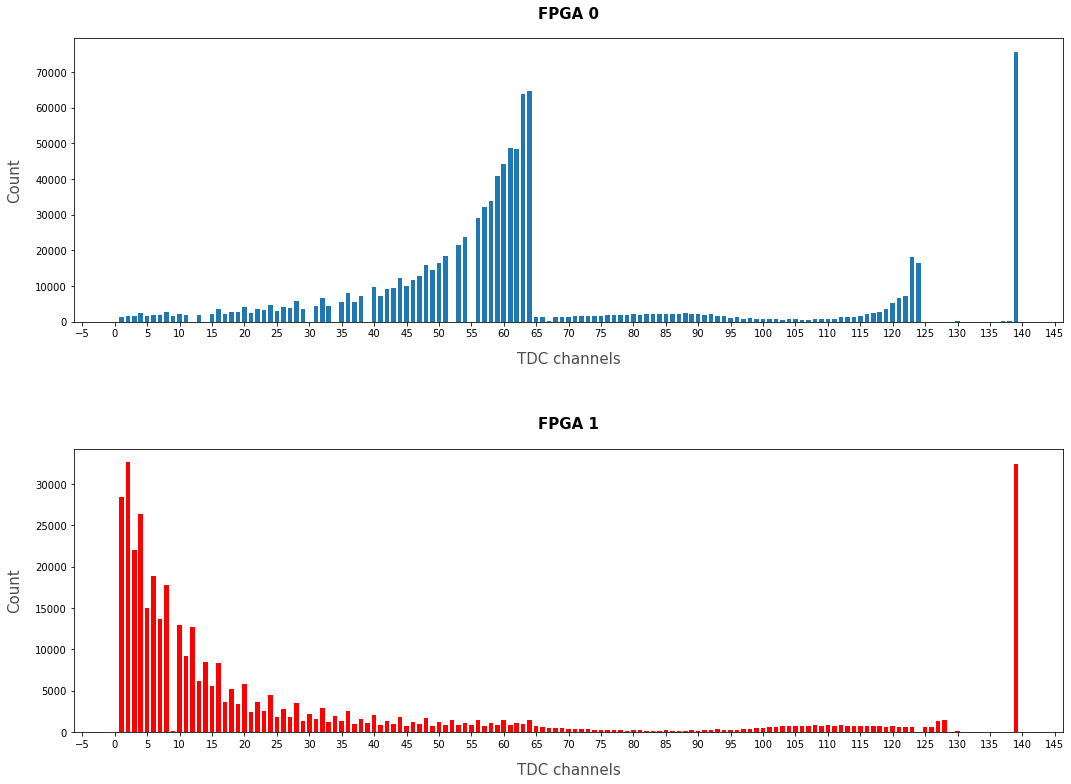

In [12]:
import matplotlib.pyplot as plt
from matplotlib.ticker import  MultipleLocator, FormatStrFormatter, AutoMinorLocator

fig, (ax1,ax2) = plt.subplots(nrows=2,figsize=(15, 11))

#FPGA_0
ax1.bar(FPGA_0.index,FPGA_0,width=0.7)
#options
ax1.xaxis.set_major_locator(MultipleLocator(5))
ax1.set_title('FPGA 0',size = 15, fontweight ="bold", pad=20)
ax1.set_xlabel('TDC channels',size = 15, labelpad  = 13, alpha=0.7)
ax1.set_ylabel('Count',size = 15, labelpad = 13, alpha=0.7)


#FPGA_1
ax2.bar(FPGA_1.index,FPGA_1, color='r',width=0.7)
#options
ax2.xaxis.set_major_locator(MultipleLocator(5))
ax2.set_title('FPGA 1',size = 15, fontweight ="bold", pad=20)
ax2.set_xlabel('TDC channels',size = 15, labelpad  = 13, alpha=0.7)
ax2.set_ylabel('Count',size = 15, labelpad = 13, alpha=0.7)

#plot
fig.tight_layout(h_pad=5)